In [2]:
# Load all of the things
import tkinter as tk
import os
import pandas as pd
import numpy as np
import scipy
import matplotlib.cm as cm
import matplotlib
import sys
import matplotlib.pyplot as plt
import peakutils
from scipy.signal import savgol_filter  # for smoothing data
from scipy.fftpack import fft
from scipy.fftpack import fftfreq
from mpl_toolkits.mplot3d import Axes3D
from peakutils.plot import plot as pplot
from tkinter import filedialog  # For folder input popup
matplotlib.rc('axes.formatter', useoffset=False)

root = tk.Tk()
root.withdraw()

######################################################################
# Data Extraction
######################################################################
trial_info = pd.read_csv(r'C:\Users\Kara\PycharmProjects\FishTrackProcessing\Data\Trial_info.csv',
                         sep=',')
trial_info = trial_info.set_index('Trial_name')

# Comment out for user input
folder = r'C:\Users\Kara\PycharmProjects\FishTrackProcessing\Data'

#  Uncomment for User Input
# folder = filedialog.askdirectory()  #Ask user for directory
# framerate = float(input('Enter frame rate in frames per second:'))

# Initialize a list of dictionaries to contain each trial's data
tracklist = {}
count = 0  # Initialize the count

for filename in os.listdir(folder):  # For all files in the directory
    if filename.endswith("xypts.csv"):  # that end with 'xypts.csv'
     
        # Extract info from filename
        filepath = folder + '/' + filename
        file_info = filename.split("_")
        fish = file_info[0]
        sequence = file_info[1]
        trial_name = fish+sequence
        framerate = trial_info['FPS'][trial_name]
        L_calib = trial_info['ScaleL_cm/px'][trial_name]
        V_calib = trial_info['ScaleV_cm/px'][trial_name]
        init_Speed = trial_info['InitialSpd_cm'][trial_name]
        fish_TL = trial_info['Fish_TL_cm'][trial_name]

        df = pd.read_csv(filepath, sep=',')
        df = df.rename(columns={'pt1_cam1_Y': 'pt1z', 'pt1_cam2_X': 'pt1x',
                                'pt1_cam2_Y': 'pt1y', 'pt2_cam1_Y': 'pt2z',
                                'pt2_cam2_X': 'pt2x', 'pt2_cam2_Y': 'pt2y'})

        # Convert position to cm
        df['pt1z'] = df['pt1z']*L_calib
        df['pt1x'] = df['pt1x']*V_calib
        df['pt1y'] = df['pt1y']*V_calib
        df['pt2z'] = df['pt2z']*L_calib
        df['pt2x'] = df['pt2x']*V_calib
        df['pt2y'] = df['pt2y']*V_calib

        # Generate time array
        df['time'] = np.linspace(0, len(df['pt1x'])*(1.0/framerate),
                                 num=len(df['pt1x']), endpoint=False)
        df = df.set_index(['time'])
       
        # Smooth position data using savitzky golay
        df['pt1x_smth'] = scipy.signal.savgol_filter(
            df['pt1x'], window_length=121, polyorder=2)
        df['pt1y_smth'] = scipy.signal.savgol_filter(
            df['pt1y'], window_length=121, polyorder=2)
        df['pt1z_smth'] = scipy.signal.savgol_filter(
            df['pt1z'], window_length=121, polyorder=2)
        
        df['pt2x_smth'] = scipy.signal.savgol_filter(
            df['pt2x'], window_length=121, polyorder=2)
        df['pt2y_smth'] = scipy.signal.savgol_filter(
            df['pt2y'], window_length=121, polyorder=2)
        df['pt2z_smth'] = scipy.signal.savgol_filter(
            df['pt2z'], window_length=121, polyorder=2)
        
        # Calculate First Discrete Differences (Velocity)     
        cols_to_use1 = ['pt1x_smth', 'pt1y_smth', 'pt1z_smth', 'pt2x_smth',
                        'pt2y_smth', 'pt2z_smth']
        df2 = df.loc[:, cols_to_use1].diff()
        df2 = df2.rename(columns={
            'pt1z_smth': 'pt1z_v', 'pt1x_smth': 'pt1x_v',
            'pt1y_smth': 'pt1y_v', 'pt2z_smth': 'pt2z_v',
            'pt2x_smth': 'pt2x_v', 'pt2y_smth': 'pt2y_v'})

        # Add initial x-velocity
        df2['pt1x_v'] = df2['pt1x_v'].sub(init_Speed)  # Because - is forward
        df2['pt2x_v'] = df2['pt2x_v'].sub(init_Speed)  # Because - is forward

        # Smooth velocity data using savitzky golay
        df2['pt1x_v_smth'] = scipy.signal.savgol_filter(
            df2['pt1x_v'], window_length=121, polyorder=3)
        df2['pt1y_v_smth'] = scipy.signal.savgol_filter(
            df2['pt1y_v'], window_length=121, polyorder=3)
        df2['pt1z_v_smth'] = scipy.signal.savgol_filter(
            df2['pt1z_v'], window_length=121, polyorder=3)

        df2['pt2x_v_smth'] = scipy.signal.savgol_filter(
            df2['pt2x_v'], window_length=121, polyorder=3)
        df2['pt2y_v_smth'] = scipy.signal.savgol_filter(
            df2['pt2y_v'], window_length=121, polyorder=3)
        df2['pt2z_v_smth'] = scipy.signal.savgol_filter(
            df2['pt2z_v'], window_length=121, polyorder=3)
        
        # Calculate Second Discrete Differences (Acceleration)   
        cols_to_use2 = ['pt1x_v_smth', 'pt1y_v_smth', 'pt1z_v_smth',
                        'pt2x_v_smth', 'pt2y_v_smth', 'pt2z_v_smth']
        df3 = df2.loc[:, cols_to_use2].diff()
        df3 = df3.rename(columns={
            'pt1z_v_smth': 'pt1z_a', 'pt1x_v_smth': 'pt1x_a',
            'pt1y_v_smth': 'pt1y_a', 'pt2z_v_smth': 'pt2z_a',
            'pt2x_v_smth': 'pt2x_a', 'pt2y_v_smth': 'pt2y_a'})

        # Merge all this shit
        df = df.merge(df2, how='outer', right_index=True, left_index=True)
        df = df.merge(df3, how='outer', left_index=True, right_index=True)
        
        # Put all of these into the appropriate object in tracklist
        tracklist[trial_name] = {'sequence': trial_name, 'fish': fish,
                                 'fish_TL': fish_TL, 'data': df}
        
        # Advance the count
        count = count + 1


C:\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Anaconda3\

In [5]:
########################################################################
# Finding Tail Beat Frequency and Amplitude
########################################################################
tail_amplitudes = {}
tail_periods = {}
for trial in tracklist:  # Iterates over all avalable trials
    trial_name = tracklist[trial]['sequence']
    fish = tracklist[trial]['fish']
    tailtip = tracklist[trial]['data']['pt2y_smth']
  

In [10]:
np.isnan(np.sum(tailtip))

False

In [8]:
base = peakutils.baseline(tailtip, deg=1)

ValueError: array must not contain infs or NaNs

In [11]:
# Detect peaks in data based on  amplitude + other features. by Marcos Duarte

from __future__ import division, print_function
import numpy as np

__author__ = "Marcos Duarte, https://github.com/demotu/BMC"
__version__ = "1.0.4"
__license__ = "MIT"

def detect_peaks(x, mph=None, mpd=1, threshold=0, edge='rising',
                 kpsh=False, valley=False, show=False, ax=None):
    """Detect peaks in data based on their amplitude and other features.
    Parameters
    ----------
    x : 1D array_like
        data.
    mph : {None, number}, optional (default = None)
        detect peaks that are greater than minimum peak height.
    mpd : positive integer, optional (default = 1)
        detect peaks that are at least separated by minimum peak distance (in
        number of data).
    threshold : positive number, optional (default = 0)
        detect peaks (valleys) that are greater (smaller) than `threshold`
        in relation to their immediate neighbors.
    edge : {None, 'rising', 'falling', 'both'}, optional (default = 'rising')
        for a flat peak, keep only the rising edge ('rising'), only the
        falling edge ('falling'), both edges ('both'), or don't detect a
        flat peak (None).
    kpsh : bool, optional (default = False)
        keep peaks with same height even if they are closer than `mpd`.
    valley : bool, optional (default = False)
        if True (1), detect valleys (local minima) instead of peaks.
    show : bool, optional (default = False)
        if True (1), plot data in matplotlib figure.
    ax : a matplotlib.axes.Axes instance, optional (default = None).
    Returns
    -------
    ind : 1D array_like
        indeces of the peaks in `x`.
    Notes
    -----
    The detection of valleys instead of peaks is performed internally by simply
    negating the data: `ind_valleys = detect_peaks(-x)`

    The function can handle NaN's
    See this IPython Notebook [1]_.
    References
    ----------
    .. [1] http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb
    Examples
    --------
    >>> from detect_peaks import detect_peaks
    >>> x = np.random.randn(100)
    >>> x[60:81] = np.nan
    >>> # detect all peaks and plot data
    >>> ind = detect_peaks(x, show=True)
    >>> print(ind)
    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # set minimum peak height = 0 and minimum peak distance = 20
    >>> detect_peaks(x, mph=0, mpd=20, show=True)
    >>> x = [0, 1, 0, 2, 0, 3, 0, 2, 0, 1, 0]
    >>> # set minimum peak distance = 2
    >>> detect_peaks(x, mpd=2, show=True)
    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # detection of valleys instead of peaks
    >>> detect_peaks(x, mph=0, mpd=20, valley=True, show=True)
    >>> x = [0, 1, 1, 0, 1, 1, 0]
    >>> # detect both edges
    >>> detect_peaks(x, edge='both', show=True)
    >>> x = [-2, 1, -2, 2, 1, 1, 3, 0]
    >>> # set threshold = 2
    >>> detect_peaks(x, threshold = 2, show=True)
    """

    x = np.atleast_1d(x).astype('float64')
    if x.size < 3:
        return np.array([], dtype=int)
    if valley:
        x = -x
    # find indexes of all peaks
    dx = x[1:] - x[:-1]
    # handle NaN's
    indnan = np.where(np.isnan(x))[0]
    if indnan.size:
        x[indnan] = np.inf
        dx[np.where(np.isnan(dx))[0]] = np.inf
    ine, ire, ife = np.array([[], [], []], dtype=int)
    if not edge:
        ine = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) > 0))[0]
    else:
        if edge.lower() in ['rising', 'both']:
            ire = \
            np.where((np.hstack((dx, 0)) <= 0) & (np.hstack((0, dx)) > 0))[0]
        if edge.lower() in ['falling', 'both']:
            ife = \
            np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) >= 0))[0]
    ind = np.unique(np.hstack((ine, ire, ife)))
    # handle NaN's
    if ind.size and indnan.size:
        # NaN's and values close to NaN's cannot be peaks
        ind = ind[np.in1d(ind, np.unique(
            np.hstack((indnan, indnan - 1, indnan + 1))), invert=True)]
    # first and last values of x cannot be peaks
    if ind.size and ind[0] == 0:
        ind = ind[1:]
    if ind.size and ind[-1] == x.size - 1:
        ind = ind[:-1]
    # remove peaks < minimum peak height
    if ind.size and mph is not None:
        ind = ind[x[ind] >= mph]
    # remove peaks - neighbors < threshold
    if ind.size and threshold > 0:
        dx = np.min(np.vstack([x[ind] - x[ind - 1], x[ind] - x[ind + 1]]),
                    axis=0)
        ind = np.delete(ind, np.where(dx < threshold)[0])
    # detect small peaks closer than minimum peak distance
    if ind.size and mpd > 1:
        ind = ind[np.argsort(x[ind])][::-1]  # sort ind by peak height
        idel = np.zeros(ind.size, dtype=bool)
        for i in range(ind.size):
            if not idel[i]:
                # keep peaks with the same height if kpsh is True
                idel = idel | (ind >= ind[i] - mpd) & (ind <= ind[i] + mpd) \
                              & (x[ind[i]] > x[ind] if kpsh else True)
                idel[i] = 0  # Keep current peak
        # remove the small peaks and sort back the indexes by their occurrence
        ind = np.sort(ind[~idel])

    if show:
        if indnan.size:
            x[indnan] = np.nan
        if valley:
            x = -x
        _plot(x, mph, mpd, threshold, edge, valley, ax, ind)

    return ind

def _plot(x, mph, mpd, threshold, edge, valley, ax, ind):
    """Plot results of the detect_peaks function, see its help."""
    try:
        import matplotlib.pyplot as plt
    except ImportError:
        print('matplotlib is not available.')
    else:
        if ax is None:
            _, ax = plt.subplots(1, 1, figsize=(8, 4))

        ax.plot(x, 'b', lw=1)
        if ind.size:
            label = 'valley' if valley else 'peak'
            label = label + 's' if ind.size > 1 else label
            ax.plot(ind, x[ind], '+', mfc=None, mec='r', mew=2, ms=8,
                    label='%d %s' % (ind.size, label))
            ax.legend(loc='best', framealpha=.5, numpoints=1)
        ax.set_xlim(-.02 * x.size, x.size * 1.02 - 1)
        ymin, ymax = x[np.isfinite(x)].min(), x[np.isfinite(x)].max()
        yrange = ymax - ymin if ymax > ymin else 1
        ax.set_ylim(ymin - 0.1 * yrange, ymax + 0.1 * yrange)
        ax.set_xlabel('Data #', fontsize=14)
        ax.set_ylabel('Amplitude', fontsize=14)
        mode = 'Valley detection' if valley else 'Peak detection'
        ax.set_title("%s (mph=%s, mpd=%d, threshold=%s, edge='%s')"
                     % (mode, str(mph), mpd, str(threshold), edge))
        # plt.grid()
        plt.show()
    

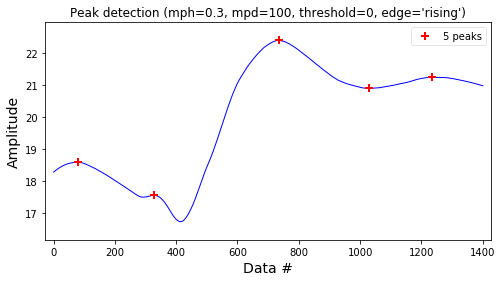

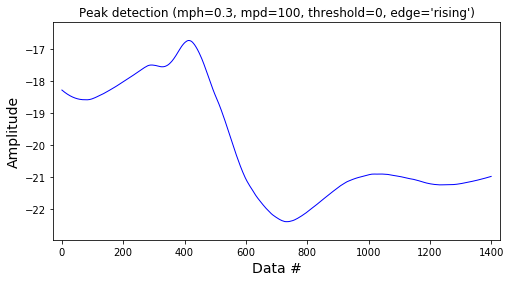

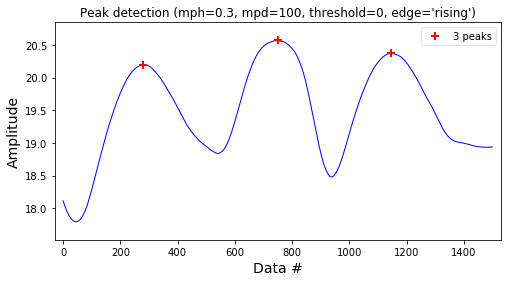

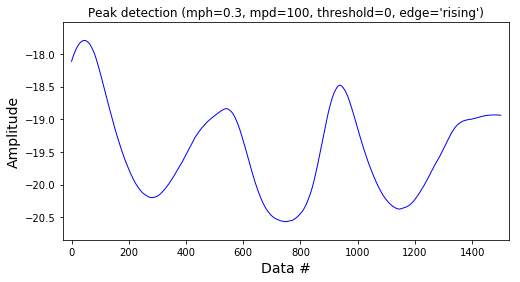

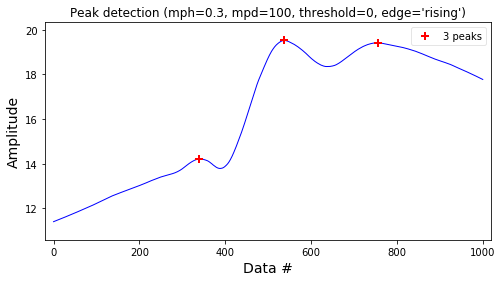

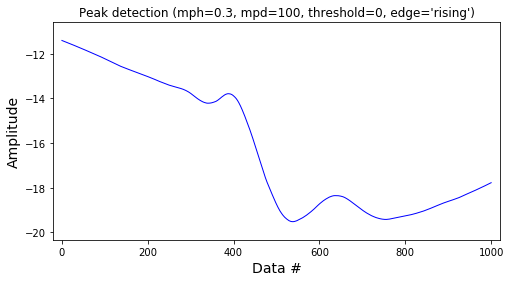

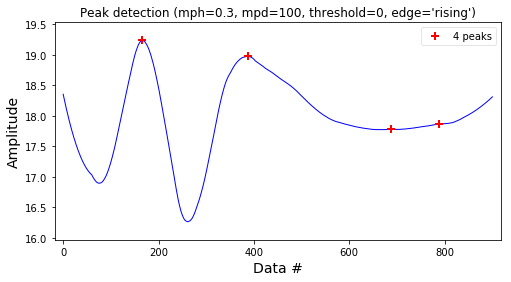

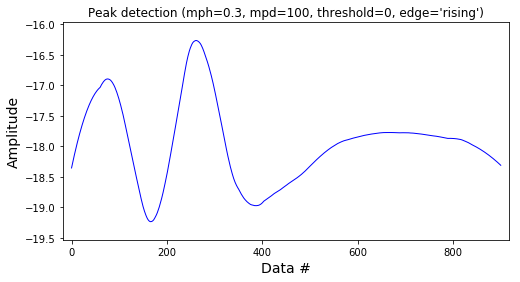

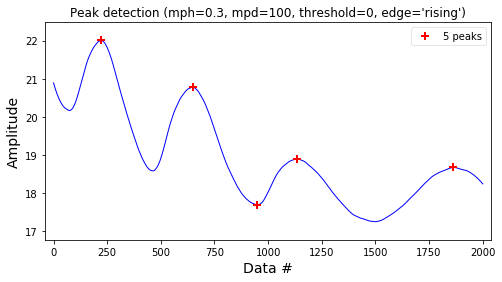

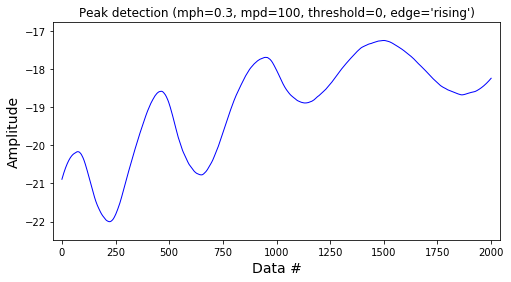

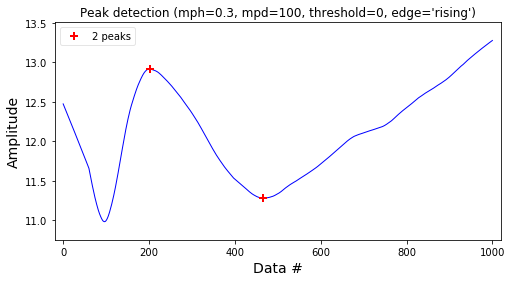

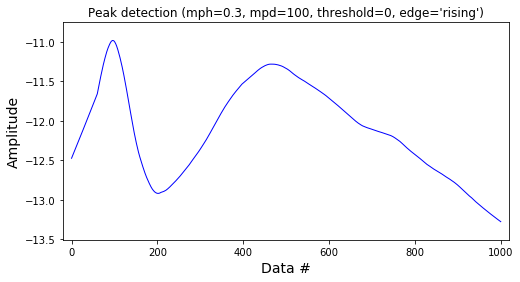

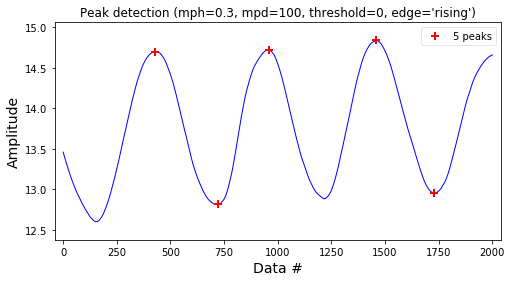

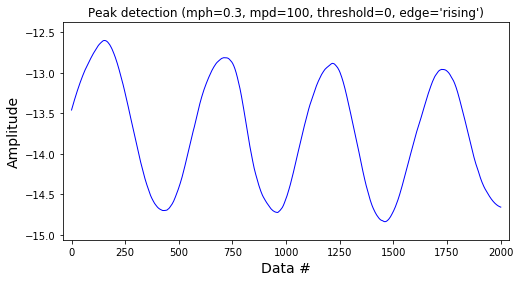

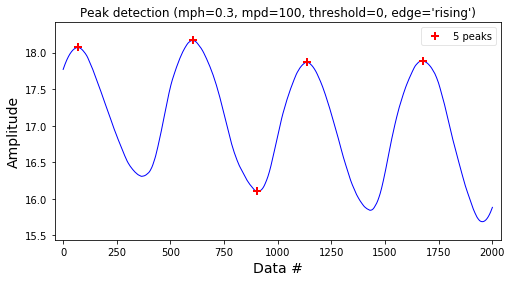

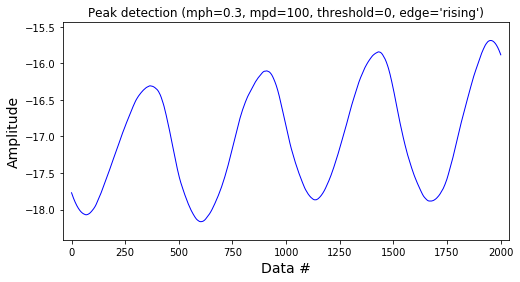

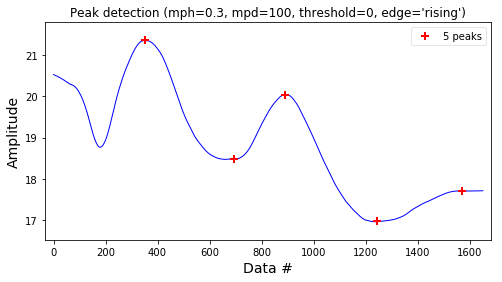

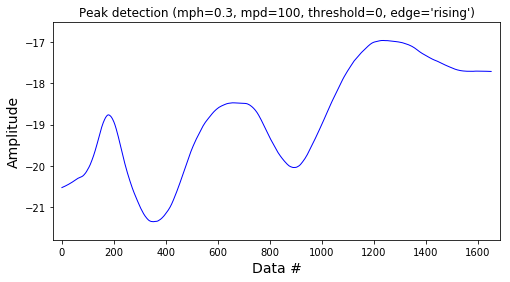

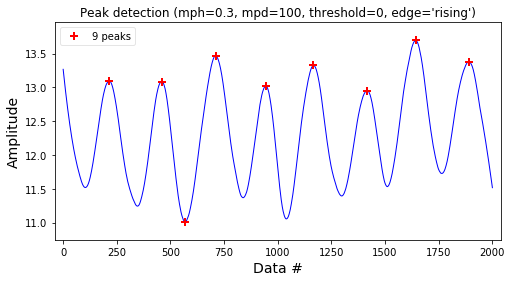

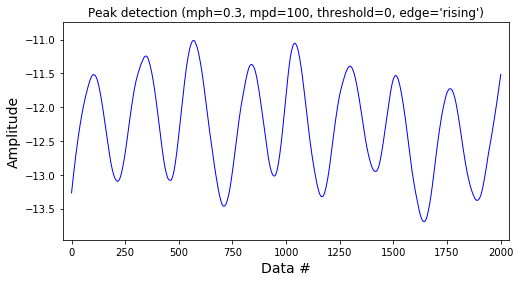

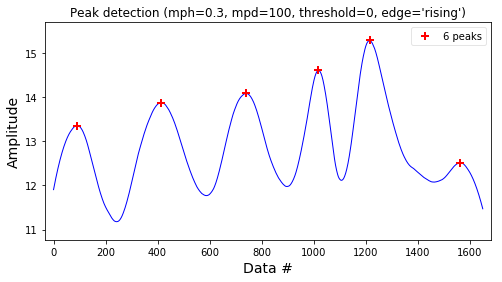

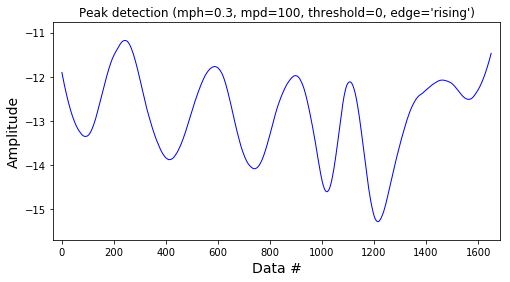

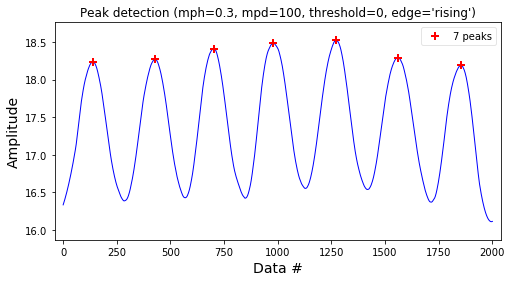

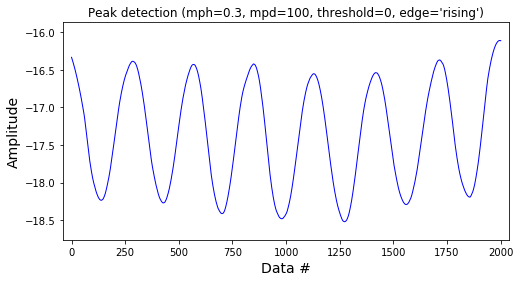

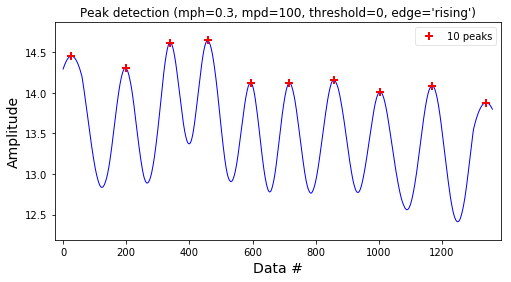

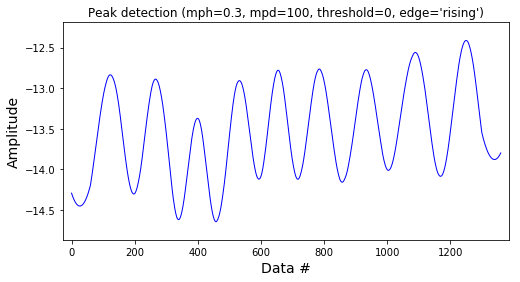

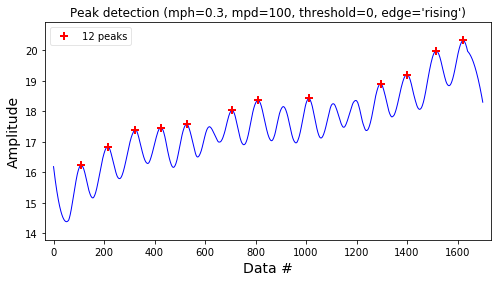

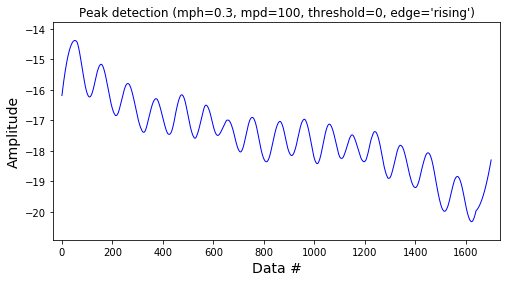

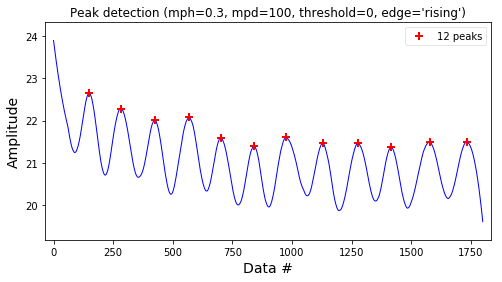

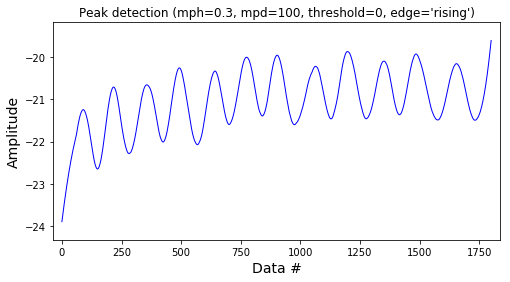

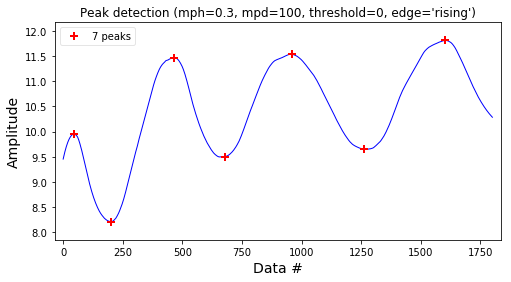

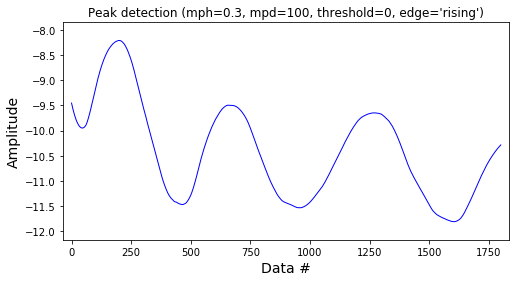

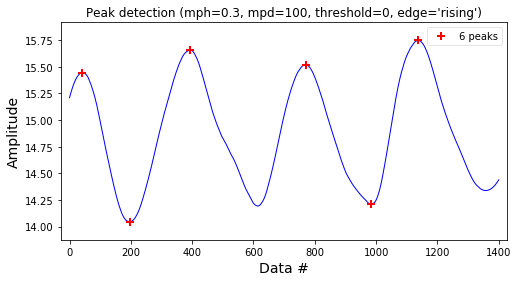

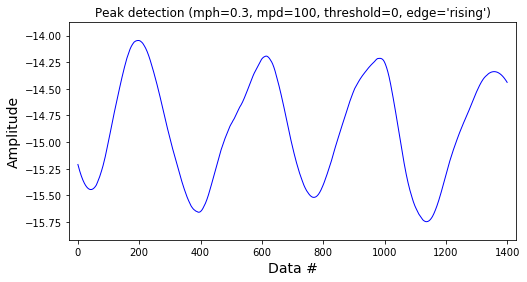

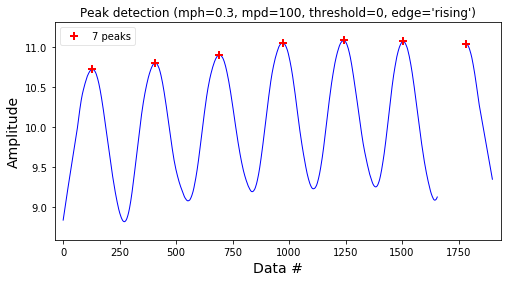

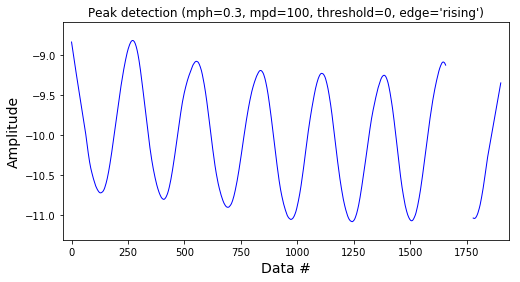

In [13]:
for trial in tracklist:  # Iterates over all avalable trials
    trial_name = tracklist[trial]['sequence']
    fish = tracklist[trial]['fish']

    # By FFT
    time = tracklist[trial]['data'].index.values
    N = time.size
    T = 1.0/framerate
    # x = np.linspace(0.0, N*T, N)
    # y = tracklist[trial]['data']['pt2y_smth'] - \
    #  np.mean(tracklist[trial]['data']['pt2y_smth'])
    # yf = fft(y)
    # xf = np.linspace(0.0, 1.0/(2.0*T), N/2)
    # fig = plt.figure()
    # plt.plot(xf, 2.0/N * np.abs(yf[0:N/2]))
    # plt.grid()
    # plt.xlim((0,20))
    # plt.show()

    # By fin beats
    # Get tailbeat position
    tailtip = tracklist[trial]['data']['pt2y_smth']

    # Find finbeat peaks
    peakindexes = detect_peaks(tailtip, mph=0.3, mpd=framerate/10, show=True)
    # Find finbeat troughs
    troughindexes = detect_peaks(-tailtip, mph=0.3, mpd=framerate/10,
                                 show=True)
    # Find when the peaks are